In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np

In [8]:
from tensor_completion.utils import unfold, fold

In [352]:
def singular_threshold(M, threshold=0.1):
    U, s, V = np.linalg.svd(M, full_matrices=False)
    s[s < threshold] = 0
    return U @ np.diag(s) @ V

def generalized_singular_threshold(M, theta, threshold=0.1):
    U, s, V = np.linalg.svd(M, full_matrices=False)
    idx = np.sum(s > threshold)
    vec = s.copy()
    vec[theta:idx] -= threshold
    return U[:, :idx] @ np.diag(vec[:idx]) @ V[:idx, :]

    # [m, n] = M.shape
    # if 2 * m < n:
    #     u, s, v = np.linalg.svd(M @ M.T, full_matrices = 0)
    #     s = np.sqrt(s)
    #     idx = np.sum(s > threshold)
    #     mid = np.zeros(idx)
    #     mid[: theta] = 1
    #     mid[theta : idx] = (s[theta : idx] - threshold) / s[theta : idx]
    #     return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ M)
    # elif m > 2 * n:
    #     return generalized_singular_threshold(M.T, threshold, theta).T
    # u, s, v = np.linalg.svd(M, full_matrices = 0)
    # idx = np.sum(s > threshold)
    # vec = s[: idx].copy()
    # vec[theta : idx] = s[theta : idx] - threshold
    # return u[:, : idx] @ np.diag(vec) @ v[: idx, :]


In [3]:
Y = np.random.rand(10, 10)

imputer(Y, 0.1, 0.1, 0.1, 0.1)

(2, 10, 10)


In [1]:
import pandas as pd

pems_path = r'C:\Antoine\Study\Master 2 - MVA\Chronological Series\Project\Low Rank Tensor Completion\data\California-data-set'
pems = pd.read_csv(pems_path + r'\pems-4w.csv', header=None)

pems.shape

(11160, 8064)

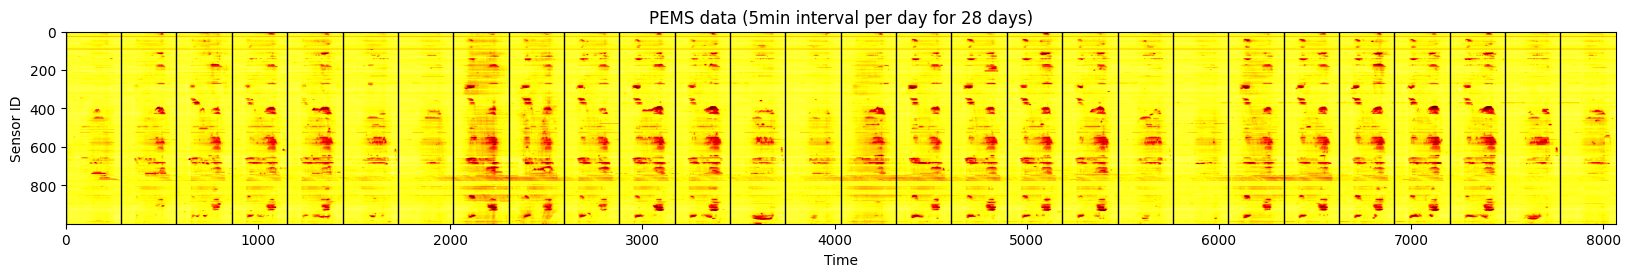

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.imshow(pems.values[:1000, :], cmap='hot')
for i in range(pems.shape[1] // 288):
    plt.axvline(x=i * 288, color='black', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Sensor ID')
plt.title('PEMS data (5min interval per day for 28 days)')
plt.show()

In [9]:
import gc

pems_tensor = fold(pems.values, 0, (pems.shape[0], 288, 28))

# del pems
# gc.collect()

In [82]:
# Create a sparse tensor with x% of missing values

def create_sparse_tensor(tensor, missing_rate=0.1):
    # Create a sparse tensor with x% of missing values
    # tensor: tensor to be sparsified
    # missing_rate: percentage of missing values
    # return: sparse tensor
    dim = tensor.shape
    tensor_size = np.prod(dim)
    missing_size = int(tensor_size * missing_rate)
    missing_indices = np.random.choice(tensor_size, missing_size, replace=False)
    sparse_tensor = tensor.copy()
    sparse_tensor.reshape(tensor_size)[missing_indices] = 0
    return sparse_tensor

pems_tensor_sparse = create_sparse_tensor(pems_tensor, 0.3)

pems_tensor.shape, pems_tensor_sparse.shape

((11160, 288, 28), (11160, 288, 28))

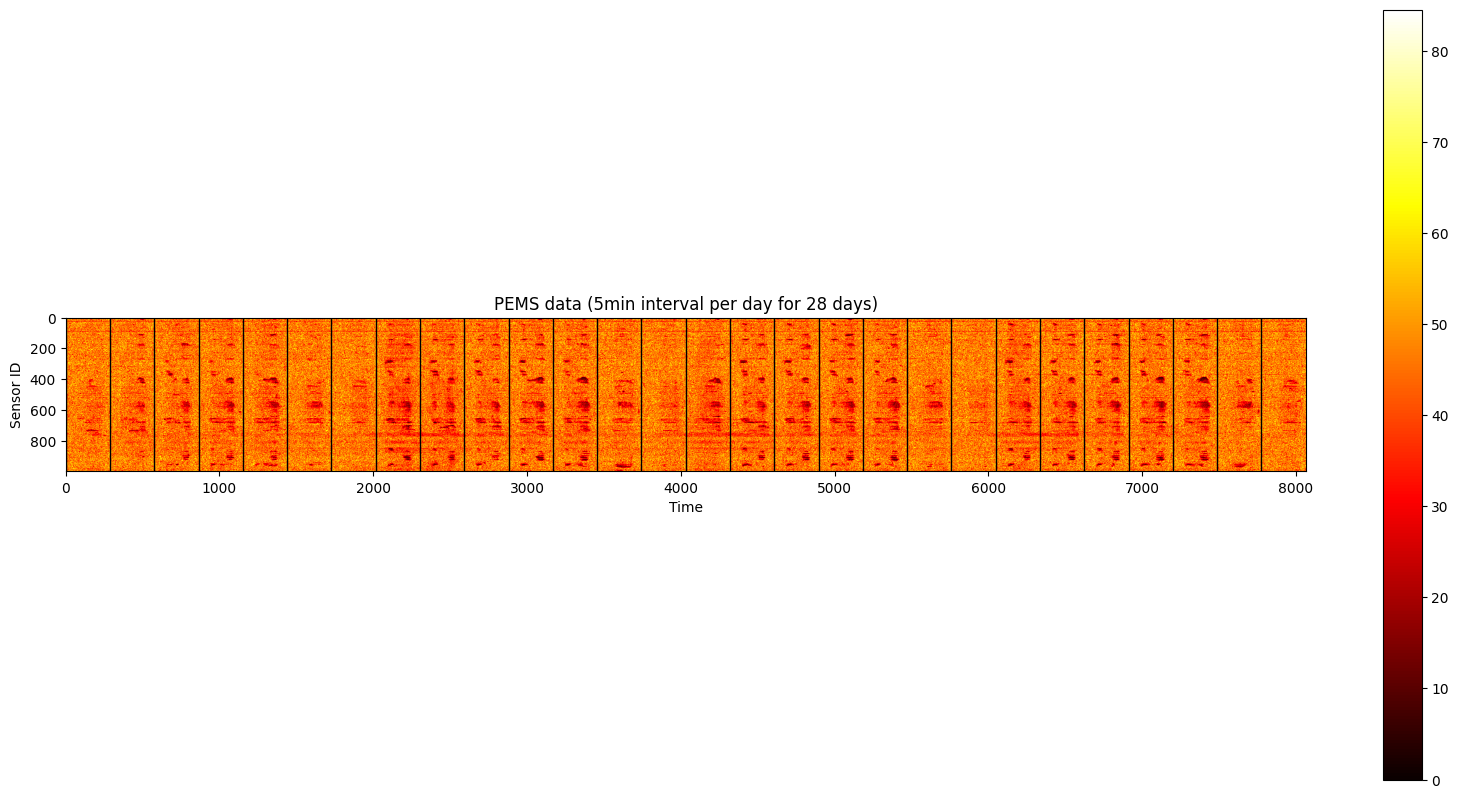

In [85]:
pems_tensor_sparse = unfold(pems_tensor_sparse, 0)


plt.figure(figsize=(20, 10))
plt.imshow(pems_tensor_sparse[:1000, :], cmap='hot')
for i in range(pems_tensor_sparse.shape[1] // 288):
    plt.axvline(x=i * 288, color='black', linewidth=1)
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Sensor ID')
plt.title('PEMS data (5min interval per day for 28 days)')
plt.show()

In [14]:
import numpy as np
# random_matrix = np.random.rand(pems.values.shape[0], 4 * 7)

# print(random_matrix.shape)

# missing_rate = 0.3

# ### Non-random missing (NM) scenario:
# binary_tensor = np.zeros(pems_tensor.shape)
# for i1 in range(pems_tensor.shape[0]):
#     for i2 in range(pems_tensor.shape[2]):
#         binary_tensor[i1, :, i2] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# sparse_tensor = np.multiply(pems_tensor, binary_tensor)

random_matrix = np.random.rand(pems.values.shape[0], 4 * 7)
print(random_matrix.shape)

missing_rate = 0.3

# Non-random missing (NM) scenario:
binary_tensor = np.round(random_matrix[:, None, :] + 0.5 - missing_rate).astype(int)
sparse_tensor = np.multiply(pems_tensor, binary_tensor)

(11160, 28)


In [15]:
sparse_tensor.shape

(11160, 288, 28)

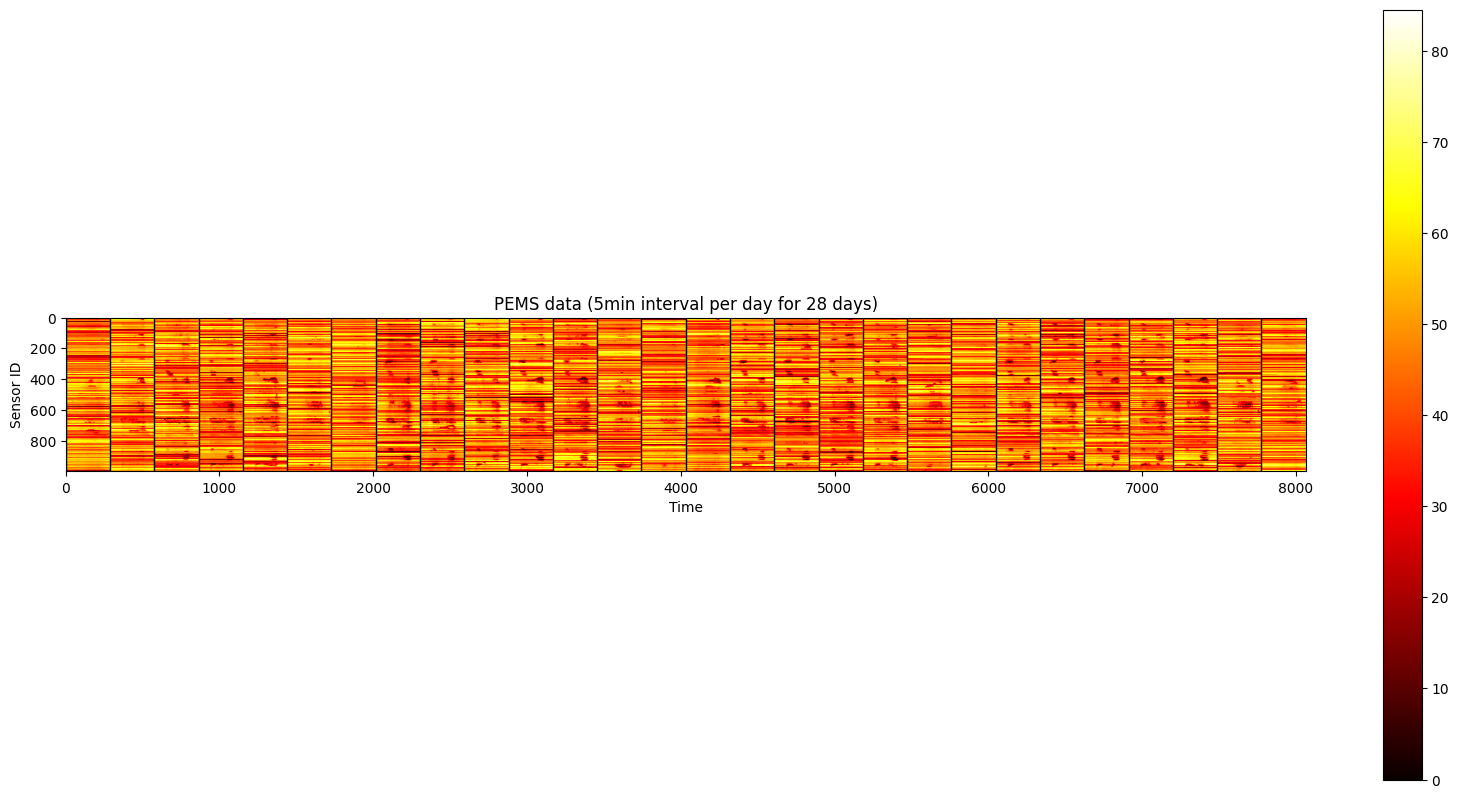

In [16]:
block_tensor_sparse = unfold(sparse_tensor, 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.imshow(block_tensor_sparse[:1000, :], cmap='hot')
for i in range(block_tensor_sparse.shape[1] // 288):
    plt.axvline(x=i * 288, color='black', linewidth=1)
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Sensor ID')
plt.title('PEMS data (5min interval per day for 28 days)')
plt.show()

In [326]:
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F


class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, input, target):
        return torch.mean(torch.abs((target - input) / target))


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, input, target):
        return torch.sqrt(torch.mean((input - target) ** 2))


In [327]:
mape_loss = MAPELoss()
rmse_loss = RMSELoss()

In [357]:
def imputer(Y_true, Y, time_lags, alpha, rho, lambd, theta, max_iterations, epsilon):
    """ADMM imputer for tensor completion

    Args:
        Y_true (np.ndarray): the true tensor
        Y (np.ndarray): the observed sparse tensor
        time_lags (np.ndarray): the time lags
        alpha (np.ndarray): the weights for each mode
        rho (float): the penalty parameter
        lambd (float): the threshold parameter
        theta (float): the threshold parameter
    """

    n_sensors, period, repeat = dim = Y.shape
    total_time = period * repeat
    max_lag = np.max(time_lags)
    n_lags = time_lags.shape[0]

    T = np.zeros((3, *dim))
    X = np.zeros((3, *dim))
    Y_flat = unfold(Y, 0)
    Z = Y_flat.copy()

    test_index = np.where((Y == 0) & (Y_true != 0))
    missing_index = np.where(unfold(Y, 0) == 0)
    Z[missing_index] = np.mean(Y_flat[Y_flat != 0])
    Y_test = torch.tensor(Y_true[test_index])

    scaling_factor = 0.001
    np.random.seed(0)
    A = np.random.rand(n_sensors, n_lags) * scaling_factor

    time_matrix = np.zeros((n_lags, total_time - max_lag))
    for i in range(len(time_lags)):
        time_matrix[i, :] = np.arange(max_lag - time_lags[i], total_time - time_lags[i])
    time_matrix = time_matrix.astype(int)

    prev_X_hat = Y_flat.copy()
    norm_Y = np.linalg.norm(Y_flat, ord='fro')

    iteration = 0
    progress_bar = tqdm(total=max_iterations)

    while True:

        for k in range(3):
            W = fold(Z, 0, dim) - T[k] / rho
            U = generalized_singular_threshold(unfold(W, k), theta, alpha[k] / rho)
            X[k] = fold(U, k, dim)

        X_hat_tensor = np.sum([alpha[k] * X[k] for k in range(3)], axis=0)
        X_hat = unfold(X_hat_tensor, 0)

        N = np.zeros((n_sensors, total_time - max_lag))
        for m in range(n_sensors):
            Qm = X_hat[m, time_matrix].T
            A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag:]
            N[m, :] = Qm @ A[m, :]

        M = unfold(np.mean(rho * X + T, axis=0), 0)

        Z[missing_index] = np.append(
            M[:, :max_lag] / rho,
            1 / (rho + lambd) * (M[:, max_lag:] + lambd * N),
            axis=1
        )[missing_index]

        T += rho * (X - fold(Z, 0, dim))

        print(T[1, 0, 0])

        tolerance = np.linalg.norm(X_hat - prev_X_hat, ord='fro') / norm_Y
        prev_X_hat = X_hat.copy()

        rho = min(1e5, rho * 1.05)

        # print(tolerance)

        mape_error = mape_loss(torch.tensor(X_hat_tensor[test_index]), Y_test)
        rmse_error = rmse_loss(torch.tensor(X_hat_tensor[test_index]), Y_test)

        iteration += 1
        progress_bar.update(1)
        progress_bar.set_description(f'{iteration}/{max_iterations} | Tolerance: {tolerance:.6} | MAPE: {mape_error:.2} | RMSE: {rmse_error:.2}')

        if tolerance < epsilon or iteration >= max_iterations: break

    progress_bar.close()

    print('Imputation finished')

    mape_error = mape_loss(torch.tensor(X_hat_tensor[test_index]), Y_test)
    rmse_error = rmse_loss(torch.tensor(X_hat_tensor[test_index]), Y_test)

    print(f'MAPE: {mape_error} | RMSE: {rmse_error}')

    return X_hat




In [358]:
# pems_tensor_sparse = fold(pems_tensor_sparse, 0, (pems_tensor_sparse.shape[0], 288, 28))


# Hyperparameters from the original paper

time_lags = np.array([1, 2, 3, 4, 5, 6] + [288 - 2, 288 - 1, 288, 288 + 1, 288 + 2, 288 + 3])
rho = 1e-4
lambd = 5*rho
theta = 15
epsilon = 1e-4

pems_tensor_2 = pems_tensor[:100]
pems_tensor_sparse_2 = pems_tensor_sparse[:100]

alpha = np.array([1/3, 1/3, 1/3])

# ADMM imputer
result = imputer(pems_tensor_2, pems_tensor_sparse_2, time_lags, alpha, rho, lambd, theta, 2, epsilon)

  0%|          | 0/2 [00:00<?, ?it/s]

[-2.78661637e-05 -2.19261594e-05 -2.57444469e-04 -2.54843772e-04
 -2.65505262e-04 -2.54280713e-04 -2.69626720e-04 -2.72945577e-04
 -7.46252596e-06 -2.32687829e-04 -2.43246319e-04 -2.22165436e-04
 -2.28489796e-04 -2.03509421e-04 -2.55950515e-04 -5.21653744e-05
 -2.18135972e-04 -2.42589276e-04 -5.73937991e-05 -2.37545478e-04
 -2.18955148e-04 -1.95956435e-04 -5.99501138e-05 -4.99505518e-05
 -3.31377833e-05 -6.64208475e-05 -2.16982077e-04 -2.16811335e-04]
[-5.83905219e-05 -6.97541733e-05 -3.69183021e-04 -3.43291161e-04
 -3.66814467e-04 -3.45143204e-04 -3.55862371e-04 -3.71800422e-04
  1.05904134e-05 -2.94546124e-04 -3.23627039e-04 -2.75617780e-04
 -3.05838925e-04 -2.76298081e-04 -3.34228107e-04 -5.08374086e-05
 -2.86019993e-04 -3.25645796e-04 -6.13655278e-05 -2.98958924e-04
 -2.66946566e-04 -2.26687541e-04 -7.99701626e-05 -6.70622911e-05
 -4.08937887e-05 -7.18673641e-05 -2.80455832e-04 -2.61847865e-04]
Imputation finished
MAPE: 0.03411412123331324 | RMSE: 3.150141667436531


In [356]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

def svt_tnn(mat, tau, theta):
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[: theta] = 1
        mid[theta : idx] = (s[theta : idx] - tau) / s[theta : idx]
        return (u[:, : idx] @ np.diag(mid)) @ (u[:, : idx].T @ mat)
    elif m > 2 * n:
        return svt_tnn(mat.T, tau, theta).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    vec = s[: idx].copy()
    vec[theta : idx] = s[theta : idx] - tau
    return u[:, : idx] @ np.diag(vec) @ v[: idx, :]

def imputer2(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, theta, epsilon, maxiter):
    """Low-Rank Autoregressive Tensor Completion, LATC-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = np.int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))


    X = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{X}}
    T = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    np.random.seed(0)
    A = 0.001 * np.random.rand(dim[0], d)     # \boldsymbol{A}

    it = 0
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    while True:
        # rho = min(rho * 1.05, 1e5)
        for k in range(len(dim)):
            X[k] = mat2ten(svt_tnn(ten2mat(mat2ten(Z, dim, 0) - T[k] / rho, k), alpha[k] / rho, theta), dim, k)
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        mat_hat = ten2mat(tensor_hat, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        if lambda0 > 0:
            for m in range(dim[0]):
                Qm = mat_hat[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                mat0[m, :] = Qm @ A[m, :]
            mat1 = ten2mat(np.mean(rho * X + T, axis = 0), 0)
            Z[pos_missing] = np.append((mat1[:, : max_lag] / rho), (mat1[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = (ten2mat(np.mean(X + T / rho, axis = 0), 0))[pos_missing]
        T = T + rho * (X - np.broadcast_to(mat2ten(Z, dim, 0), np.insert(dim, 0, len(dim))))
        print(T[1, 0, 0])
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        print(tol)
        it += 1
        if (tol < epsilon) or (it >= maxiter):
            break

    return tensor_hat

result = imputer2(pems_tensor_2, pems_tensor_sparse_2, time_lags, alpha, rho, lambd, theta, epsilon, 2)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_99100\293338759.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dim_time = np.int(np.prod(dim) / dim[0])


[-2.78661637e-05 -2.19261594e-05 -2.57444469e-04 -2.54843772e-04
 -2.65505262e-04 -2.54280713e-04 -2.69626720e-04 -2.72945577e-04
 -7.46252596e-06 -2.32687829e-04 -2.43246319e-04 -2.22165436e-04
 -2.28489796e-04 -2.03509421e-04 -2.55950515e-04 -5.21653744e-05
 -2.18135972e-04 -2.42589276e-04 -5.73937991e-05 -2.37545478e-04
 -2.18955148e-04 -1.95956435e-04 -5.99501138e-05 -4.99505518e-05
 -3.31377833e-05 -6.64208475e-05 -2.16982077e-04 -2.16811335e-04]
0.6543453508319336
[-5.69572325e-05 -6.80612702e-05 -3.60165697e-04 -3.34891755e-04
 -3.57829101e-04 -3.36697014e-04 -3.47147675e-04 -3.62696002e-04
  1.21277837e-05 -2.87317315e-04 -3.15676854e-04 -2.68835409e-04
 -2.98313760e-04 -2.69502277e-04 -3.26009437e-04 -4.77415800e-05
 -2.78976924e-04 -3.17626059e-04 -5.80859237e-05 -2.91583115e-04
 -2.60368689e-04 -2.21082862e-04 -7.63505846e-05 -6.36323589e-05
 -3.76893850e-05 -6.80687005e-05 -2.73576039e-04 -2.55420483e-04]
0.045984606800217
